In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, MaxPooling3D, BatchNormalization, Activation, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report


# Data Preprocessing(AI hub)

In [3]:
# training data
df1 = pd.read_csv('./누수감지데이터셋(Training)/out_training.csv')
df2 = pd.read_csv('./누수감지데이터셋(Training)/in_training.csv')
df3 = pd.read_csv('./누수감지데이터셋(Training)/noise_training.csv')
df4 = pd.read_csv('./누수감지데이터셋(Training)/other_training.csv')
df5 = pd.read_csv('./누수감지데이터셋(Training)/normal_training.csv')

In [4]:
# validation data
dfv1 = pd.read_csv('./누수감지데이터셋(Validation)/in_validation.csv')
dfv2 = pd.read_csv('./누수감지데이터셋(Validation)/out_validation.csv')
dfv3 = pd.read_csv('./누수감지데이터셋(Validation)/noise_validation.csv')
dfv4 = pd.read_csv('./누수감지데이터셋(Validation)/other_validation.csv')
dfv5 = pd.read_csv('./누수감지데이터셋(Validation)/normal_validation.csv')

In [5]:
dfv3.shape

(629, 539)

In [6]:
#train, validation data concat
train = pd.concat([df1,df2,df3,df4,df5], ignore_index=True)
validation = pd.concat([dfv1,dfv2,dfv3,dfv4,dfv5], ignore_index=True)
training_data = train.copy()
validation_data = validation.copy()
print(training_data.shape, validation_data.shape)

(62564, 539) (7820, 539)


In [7]:
# label encodong 
encode_dict = {'out':0, 'in':1, 'noise':2, 'other':3, 'normal':4}
training_data['leaktype_encoded'] = training_data['leaktype'].map(encode_dict)
validation_data['leaktype_encoded'] = validation_data['leaktype'].map(encode_dict)
col =['{}HZ'.format(10*i) for i in range(513)]
col.append('leaktype_encoded')
training_data = training_data[col]
validation_data = validation_data[col]
validation_data

,0HZ,10HZ,20HZ,30HZ,40HZ,50HZ,60HZ,70HZ,80HZ,90HZ,...,5040HZ,5050HZ,5060HZ,5070HZ,5080HZ,5090HZ,5100HZ,5110HZ,5120HZ,leaktype_encoded
0,0,3,4,4,4,4,4,3,4,4,...,6,6,5,6,7,6,6,5,6,1
1,0,0,0,3,0,3,0,0,3,0,...,0,3,3,3,3,3,3,3,3,1
2,0,16,19,25,52,53,39,41,48,51,...,4,3,4,4,4,5,5,5,4,1
3,0,3,0,3,3,3,3,3,3,0,...,3,3,3,3,3,3,3,3,3,1
4,0,7,5,5,7,8,5,6,5,6,...,5,7,6,5,5,5,6,6,6,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7815,0,3,4,4,4,5,4,4,4,4,...,6,7,7,6,5,7,5,6,7,4
7816,0,4,4,4,5,4,4,4,4,4,...,5,6,6,6,6,6,6,5,5,4
7817,0,4,4,4,5,4,4,4,4,5,...,7,6,6,7,7,6,6,5,6,4
7818,0,4,4,4,4,4,4,4,4,4,...,5,6,5,6,6,5,4,4,6,4


In [8]:
# level by frequency list로 생성
training_data['freq'] = training_data.apply(lambda row: row['10HZ':'5120HZ'].values.tolist(), axis=1)
validation_data['freq'] = validation_data.apply(lambda row: row['10HZ':'5120HZ'].values.tolist(), axis=1)



In [9]:
# def MinmaxScaling(lst):
#     arr = np.array(lst)
#     min_val = np.min(arr)
#     max_val = np.max(arr)
#     scaled_arr = (arr - min_val) / (max_val - min_val)
#     return scaled_arr.tolist()

In [50]:
# hub_data['freq'] = hub_data['freq'].apply(MinmaxScaling)

/var/folders/7d/m8201j1j3bl4hbw7mx0r8_k00000gn/T/ipykernel_35500/1626995079.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hub_data['freq'] = hub_data['freq'].apply(MinmaxScaling)


# Model

In [15]:
X_train = np.array(training_data['freq'].apply(lambda x: np.array(x).reshape(32, 16, 1)).tolist())
y = training_data['leaktype_encoded']

X_test = np.array(validation_data['freq'].apply(lambda x: np.array(x).reshape(32, 16, 1)).tolist())
y_val = validation_data['leaktype_encoded']

y_train = to_categorical(y)
y_test = to_categorical(y_val)


# Define the model
model = Sequential([
    BatchNormalization(input_shape=(32, 16, 1)),
    Conv2D(16, kernel_size=5, padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(32, kernel_size=5, padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(64, kernel_size=5, padding='same', activation='relu'),
    MaxPooling2D(pool_size=(3, 3), strides=3),
    Flatten(),
    Dense(3200, activation='relu'),
    Dense(y_train.shape[1], activation='softmax')  # y_train.shape[1] : n of classes
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



# Train and Test


In [16]:
# Train the model
model.fit(X_train, y_train, validation_split=0.2, batch_size=64, epochs=30)


Epoch 1/30
978/978 [==============================] - 83s 85ms/step - loss: 0.9843 - accuracy: 0.6210 - val_loss: 0.7274 - val_accuracy: 0.7119
Epoch 2/30
978/978 [==============================] - 83s 85ms/step - loss: 0.6054 - accuracy: 0.7668 - val_loss: 0.4718 - val_accuracy: 0.8277
Epoch 3/30
978/978 [==============================] - 83s 85ms/step - loss: 0.3783 - accuracy: 0.8643 - val_loss: 0.3579 - val_accuracy: 0.8784
Epoch 4/30
978/978 [==============================] - 80s 82ms/step - loss: 0.2577 - accuracy: 0.9115 - val_loss: 0.2778 - val_accuracy: 0.9052
Epoch 5/30
978/978 [==============================] - 82s 84ms/step - loss: 0.1832 - accuracy: 0.9374 - val_loss: 0.2296 - val_accuracy: 0.9265
Epoch 6/30
978/978 [==============================] - 81s 83ms/step - loss: 0.1413 - accuracy: 0.9524 - val_loss: 0.2267 - val_accuracy: 0.9325
Epoch 7/30
978/978 [==============================] - 80s 82ms/step - loss: 0.1088 - accuracy: 0.9628 - val_loss: 0.2148 - val_accuracy:

245/245 [==============================] - 3s 13ms/step


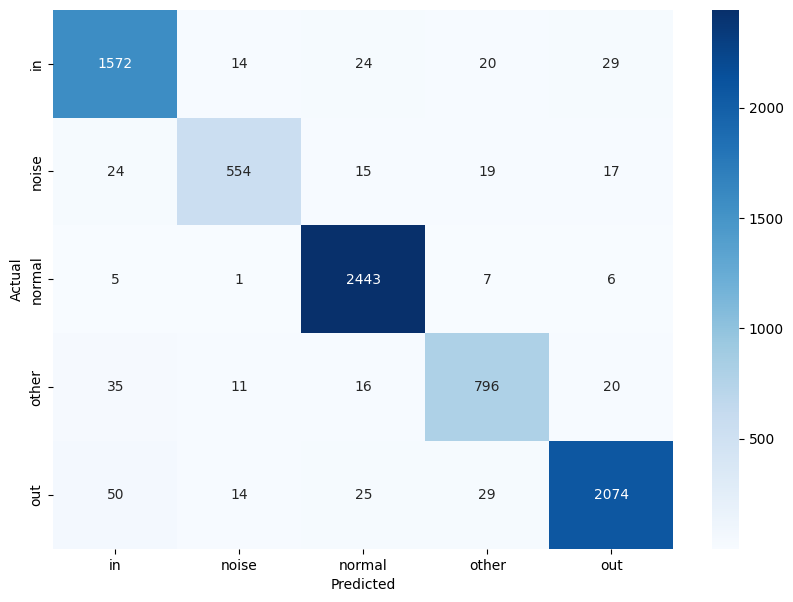

In [26]:
y_pred = model.predict(X_test)
y_true = y_test

y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)


encode_inverse = {0:'out', 1:'in', 2:'noise', 3:'other', 4:'normal'}

y_pred_label = pd.Series(y_pred_classes).map(encode_inverse)
y_true_label = pd.Series(y_true).map(encode_inverse)

# Generate the confusion matrix
conf_mat = confusion_matrix(y_true_label, y_pred_label)

class_labels = ['in', 'noise', 'normal', 'other' ,'out']

plt.figure(figsize=(10,7))
sns.heatmap(conf_mat,annot=True,fmt='d', cmap='Blues', xticklabels = class_labels, yticklabels = class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [27]:
report= classification_report(y_true_label, y_pred_label)
print(report)

              precision    recall  f1-score   support

          in       0.93      0.95      0.94      1659
       noise       0.93      0.88      0.91       629
      normal       0.97      0.99      0.98      2462
       other       0.91      0.91      0.91       878
         out       0.97      0.95      0.96      2192

    accuracy                           0.95      7820
   macro avg       0.94      0.93      0.94      7820
weighted avg       0.95      0.95      0.95      7820



# Frequency Range 지정

In [51]:
col =['{}HZ'.format(10*i) for i in range(1,513)]
col.append('leaktype')
train_mean = train[col].groupby('leaktype').mean()
train_mean

,10HZ,20HZ,30HZ,40HZ,50HZ,60HZ,70HZ,80HZ,90HZ,100HZ,...,5030HZ,5040HZ,5050HZ,5060HZ,5070HZ,5080HZ,5090HZ,5100HZ,5110HZ,5120HZ
leaktype,,,,,,,,,,,,,,,,,,,,,
in,6.568673,6.802305,7.237475,8.085889,9.004294,14.364951,8.766971,9.290439,10.063512,11.502524,...,8.828449,8.803436,8.796353,8.824079,8.819408,8.785655,8.822120,8.851277,8.830558,8.849167
noise,4.493140,5.059853,5.666136,6.284152,6.620203,30.509246,7.387950,7.801153,8.679459,10.731955,...,4.807715,4.778684,4.777491,4.713263,4.701531,4.741102,4.643667,4.607874,4.580831,4.504076
normal,4.260607,4.435445,4.629720,4.711226,4.827903,5.488124,4.931384,5.197016,5.593534,6.044559,...,6.398904,6.372564,6.365560,6.371803,6.355867,6.347391,6.339322,6.323944,6.322320,6.318971
other,5.365579,5.773187,6.271121,6.352329,6.578145,12.923351,7.426556,7.902835,9.367004,10.579285,...,7.684286,7.626443,7.628437,7.638410,7.643112,7.691552,7.678587,7.630147,7.631856,7.681579
out,5.733109,6.025372,6.388563,6.859969,7.373796,8.555505,8.056104,8.771424,10.243115,11.968812,...,6.962484,6.923257,6.886196,6.817435,6.779235,6.755459,6.726153,6.728377,6.692400,6.676207


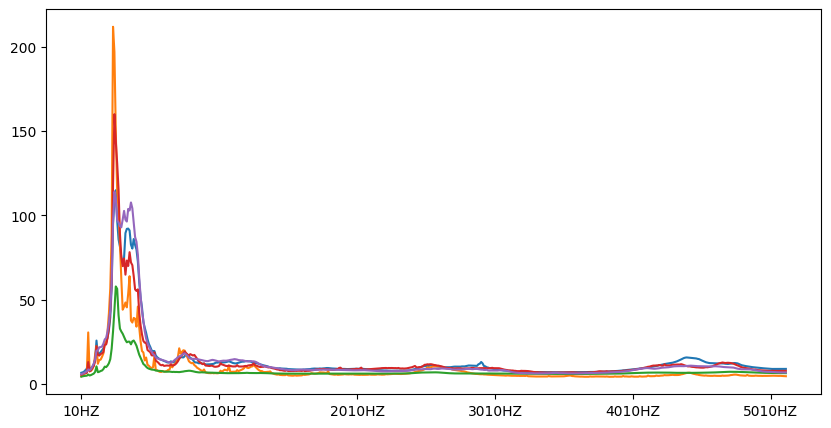

In [54]:
for i in range(5):
    train_mean.iloc[i].plot(figsize=(10, 5))
plt.show()

In [57]:
# 10HZ~2560HZ
cols =['{}HZ'.format(10*i) for i in range(1,257)]
cols.append('leaktype')

training_data_range = train[cols]
validation_data_range = validation[cols]

training_data_range['leaktype_encoded'] = training_data_range['leaktype'].map(encode_dict)
validation_data_range['leaktype_encoded'] = validation_data_range['leaktype'].map(encode_dict)

/var/folders/7d/m8201j1j3bl4hbw7mx0r8_k00000gn/T/ipykernel_67250/972945285.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_data_range['leaktype_encoded'] = training_data_range['leaktype'].map(encode_dict)
/var/folders/7d/m8201j1j3bl4hbw7mx0r8_k00000gn/T/ipykernel_67250/972945285.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_data_range['leaktype_encoded'] = validation_data_range['leaktype'].map(encode_dict)


In [59]:
training_data_range['freq'] = training_data_range.apply(lambda row: row['10HZ':'2560HZ'].values.tolist(), axis=1)
validation_data_range['freq'] = validation_data_range.apply(lambda row: row['10HZ':'2560HZ'].values.tolist(), axis=1)

/var/folders/7d/m8201j1j3bl4hbw7mx0r8_k00000gn/T/ipykernel_67250/3385669202.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_data_range['freq'] = training_data_range.apply(lambda row: row['10HZ':'2560HZ'].values.tolist(), axis=1)
/var/folders/7d/m8201j1j3bl4hbw7mx0r8_k00000gn/T/ipykernel_67250/3385669202.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_data_range['freq'] = validation_data_range.apply(lambda row: row['10HZ':'2560HZ'].values.tolist(), axis=1)


In [60]:
# input matrix 16x16으로 변환
X_train = np.array(training_data_range['freq'].apply(lambda x: np.array(x).reshape(16, 16, 1)).tolist())
y = training_data_range['leaktype_encoded']

X_test = np.array(validation_data_range['freq'].apply(lambda x: np.array(x).reshape(16, 16, 1)).tolist())
y_val = validation_data_range['leaktype_encoded']

y_train = to_categorical(y)
y_test = to_categorical(y_val)


model_r = Sequential([
    BatchNormalization(input_shape=(16, 16, 1)),
    Conv2D(16, kernel_size=5, padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(32, kernel_size=5, padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(64, kernel_size=5, padding='same', activation='relu'),
    MaxPooling2D(pool_size=(3, 3), strides=3),
    Flatten(),
    Dense(3200, activation='relu'),
    Dense(y_train.shape[1], activation='softmax')  # y_train.shape[1] gives the number of classes
])

# Compile the model
model_r.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [62]:
model_r.fit(X_train, y_train, validation_split=0.2, batch_size=64, epochs=30)

Epoch 1/30
978/978 [==============================] - 46s 47ms/step - loss: 0.6822 - accuracy: 0.7307 - val_loss: 0.5544 - val_accuracy: 0.7937
Epoch 2/30
978/978 [==============================] - 45s 46ms/step - loss: 0.4308 - accuracy: 0.8428 - val_loss: 0.4140 - val_accuracy: 0.8477
Epoch 3/30
978/978 [==============================] - 49s 50ms/step - loss: 0.2879 - accuracy: 0.8997 - val_loss: 0.2969 - val_accuracy: 0.9027
Epoch 4/30
978/978 [==============================] - 47s 48ms/step - loss: 0.2133 - accuracy: 0.9273 - val_loss: 0.2673 - val_accuracy: 0.9202
Epoch 5/30
978/978 [==============================] - 46s 47ms/step - loss: 0.1631 - accuracy: 0.9435 - val_loss: 0.2324 - val_accuracy: 0.9317
Epoch 6/30
978/978 [==============================] - 47s 48ms/step - loss: 0.1318 - accuracy: 0.9551 - val_loss: 0.2537 - val_accuracy: 0.9280
Epoch 7/30
978/978 [==============================] - 45s 46ms/step - loss: 0.1074 - accuracy: 0.9629 - val_loss: 0.2464 - val_accuracy:

245/245 [==============================] - 2s 8ms/step


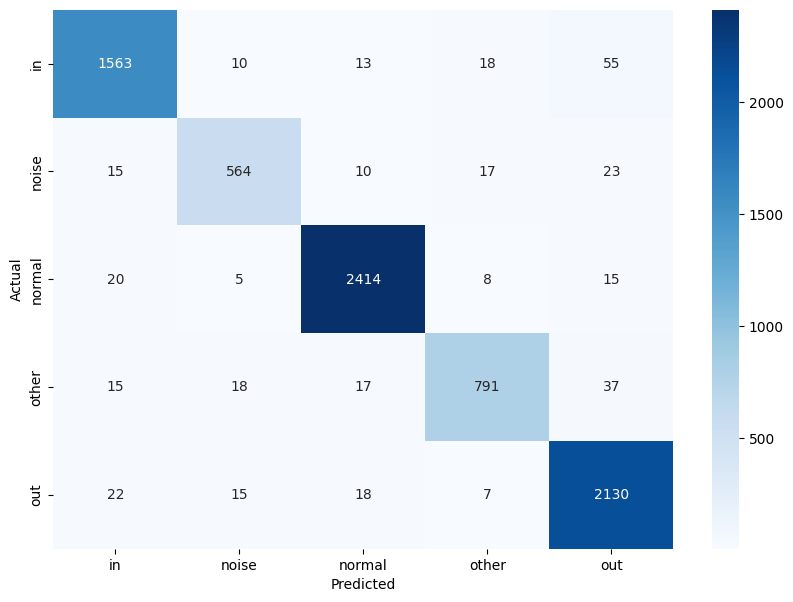

In [64]:
y_pred = model_r.predict(X_test)
y_true = y_test

y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)


encode_inverse = {0:'out', 1:'in', 2:'noise', 3:'other', 4:'normal'}

y_pred_label = pd.Series(y_pred_classes).map(encode_inverse)
y_true_label = pd.Series(y_true).map(encode_inverse)

# Generate the confusion matrix
conf_mat = confusion_matrix(y_true_label, y_pred_label)

class_labels = ['in', 'noise', 'normal', 'other' ,'out']

plt.figure(figsize=(10,7))
sns.heatmap(conf_mat,annot=True,fmt='d', cmap='Blues', xticklabels = class_labels, yticklabels = class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [65]:
report_r = classification_report(y_true_label, y_pred_label)
print(report_r)

              precision    recall  f1-score   support

          in       0.96      0.94      0.95      1659
       noise       0.92      0.90      0.91       629
      normal       0.98      0.98      0.98      2462
       other       0.94      0.90      0.92       878
         out       0.94      0.97      0.96      2192

    accuracy                           0.95      7820
   macro avg       0.95      0.94      0.94      7820
weighted avg       0.95      0.95      0.95      7820

